In [15]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>
''')

# Density surfaces

In [5]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset

import vtk
from mayavi import mlab
mlab.init_notebook('png', local=False, width=1024,height=768) #'png' or 'x3d'

import cmocean
import matplotlib.colors as colors

def its(nts):
    transects = {1: list(range(3, 11)), 2: list(reversed(range(11, 19))), 3: list(range(19, 28)),
             4: list(reversed(range(27, 35))), 5: list(range(37, 47)), 6: list(reversed(range(47, 58))),
             7: list(range(57, 66)), 8: list(range(69, 77)), 9: list(reversed(range(77, 85))),
             10: list(range(85, 92)), 11: list(reversed([94, 93] + list(range(95, 102))))}
    return np.asarray(transects[nts]) - 3 # 2 for test stations and 1 for python index starting at 0

def change_cmap(plot_name, cmap, ncolors=256):    
    plot_name.module_manager.scalar_lut_manager.lut.table = np.round(colors.makeMappingArray(ncolors, cmap)*255)
    return plot_name

Notebook initialized with png backend.


In [6]:
# load bathymetry (1 arc-minute resolution)
bathy = Dataset(os.path.join(datadir, 'external', 'bathymetry', 'bodc_res1min', 
                             'GRIDONE_2D_137.0_-52.2_145.0_-48.0.nc'))

# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

# neglect first 2 stations
lon = ctd['lon'][2:, 1]
lat = ctd['lat'][2:, 1]
z = ctd['z'][2:, :]

sigma0, mask = ctd['sigma0'][2:, :].data, ctd['sigma0'][2:, :].mask
sigma0[mask] = np.nan

CT, mask = ctd['CT'][2:,].data, ctd['CT'][2:,].mask
CT[mask] = np.nan

# plot ctd locations at the surface level
loc = np.zeros(lon.shape)

In [8]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
p_ref = 1500
p_int = 500

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])
D = D[2:]

# find z values of predefined sigma0 levels
level1, level2 = 26.8, 27.2
idx1 = np.nanargmin(abs(sigma0-level1), axis=1)
idx2 = np.nanargmin(abs(sigma0-level2), axis=1)
z_sig1 = np.zeros(sigma0.shape[0])
z_sig2 = np.zeros(sigma0.shape[0])
for i in range(sigma0.shape[0]):
    z_sig1[i] = z[i, idx1[i]]
    z_sig2[i] = z[i, idx2[i]]

# mesh bathymetry
loni, lati = np.meshgrid(bathy['lon'], bathy['lat'])
elev = bathy['elevation'][:]

# Mayavi requires col, row ordering. GDAL reads in row, col (i.e y, x) order
elev = np.rollaxis(elev,0,2)
loni = np.rollaxis(loni,0,2)
lati = np.rollaxis(lati,0,2)


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]



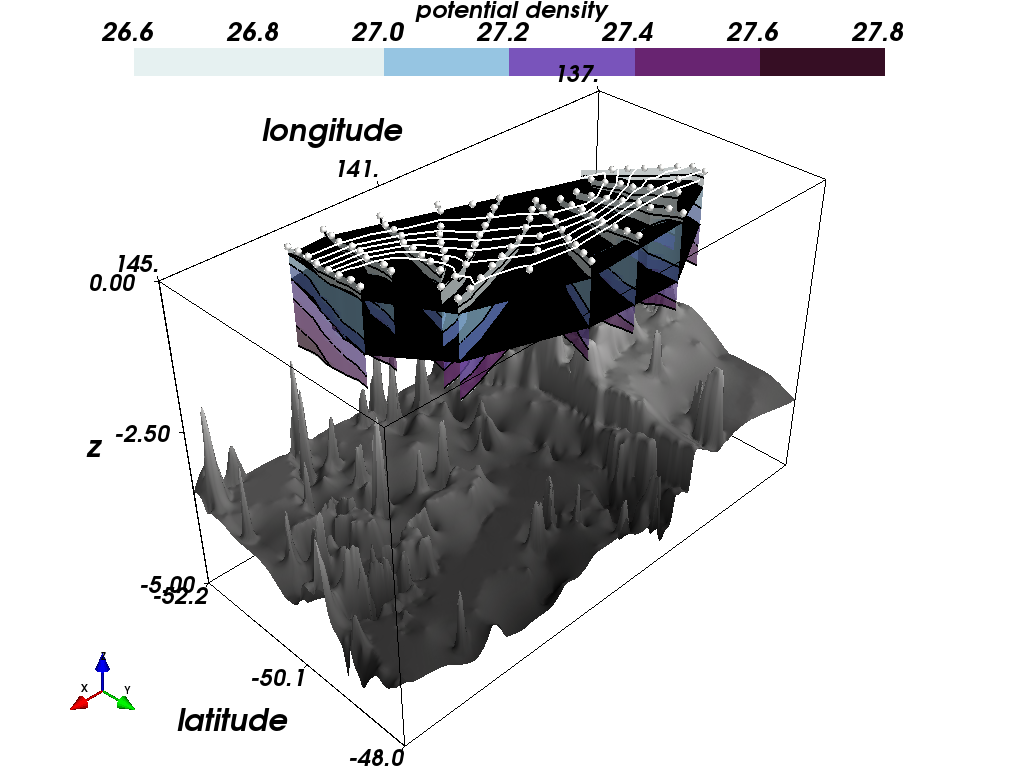

In [9]:
# plot
fig = mlab.figure(size=(1024,768), bgcolor=(1,1,1), fgcolor=(0,0,0))

# scale factor for z-axis
scalefac = 1e-3

# plot sigma0 level 1
pts1 = mlab.points3d(lon, lat, z_sig1, z_sig1, scale_mode='none', scale_factor=0.001)
pts1.actor.actor.scale = (1, 1, scalefac)
mesh1 = mlab.pipeline.delaunay2d(pts1)
surf1 = mlab.pipeline.surface(mesh1, opacity=1, color=(0,0,0))
surf1.actor.actor.scale = [1, 1, scalefac]

# plot sigma0 level 2
pts2 = mlab.points3d(lon, lat, z_sig2, z_sig2, scale_mode='none', scale_factor=0.001)
pts2.actor.actor.scale = (1, 1, scalefac)
mesh2 = mlab.pipeline.delaunay2d(pts2)
surf2 = mlab.pipeline.surface(mesh2, opacity=1, color=(0,0,0))
surf2.actor.actor.scale = [1, 1, scalefac]

ncolors = 6
# plot for each transect
for i in range(1,12):
    sig0 = sigma0[its(i)]
    sig0[np.isnan(sig0)] = 0
    
    z = np.tile(-ctd['p'][:], (len(its(i)),1))
    x = np.meshgrid(ctd['p'], lon[its(i)])[1]
    y = np.meshgrid(ctd['p'], lat[its(i)])[1]
    
    # plot potential density fields
    msh = mlab.mesh(x, y, z, scalars=sig0, opacity=0.7, vmin=26.6, vmax=27.8)
    msh.actor.actor.scale = (1, 1, scalefac)
    change_cmap(msh, cmocean.cm.dense, ncolors=ncolors)
    msh.module_manager.scalar_lut_manager.number_of_colors = ncolors

    # plot potential density contours
    mesh = mlab.pipeline.grid_source(x, y, z, scalars=sig0)
    cs = mlab.pipeline.contour_surface(mesh, contours=[26.6, 26.8, 27., 27.2, 27.4, 27.6], color=(0, 0, 0))
    cs.actor.actor.scale = (1, 1, scalefac)
    cs.actor.mapper.scalar_visibility = False
colorbar = mlab.colorbar(msh, title='potential density', orientation='horizontal', nb_colors=ncolors, nb_labels=ncolors+1)
colorbar.scalar_bar_representation.position = [0.1, 0.9]
colorbar.scalar_bar_representation.position2 = [0.8, 0.1]

# plot dynamic height contours
iD = np.where(np.isfinite(D[2:]))[0]
ptsD = mlab.points3d(lon[iD], lat[iD], loc[iD], D[iD], color=(1, 1, 0.99), scale_mode='none', scale_factor=0.1)
mesh = mlab.pipeline.delaunay2d(ptsD)
cont = mlab.pipeline.contour_surface(mesh, contours=[0.72, 0.76, 0.8, 0.84, 0.88, 0.92], color=(1, 1, 1))
cont.actor.actor.scale = [1, 1, scalefac]
cont.actor.mapper.scalar_visibility = False

# plot bathymetry
dep = mlab.surf(loni, lati, elev, warp_scale=scalefac)
change_cmap(dep, cmocean.cm.gray)

mlab.outline(extent=[137, 145, -52.2, -48, -5000*scalefac, 0])
mlab.axes(xlabel='longitude', ylabel='latitude', zlabel='z', 
          extent=[137, 145, -52.2, -48, -5000*scalefac, 0], nb_labels=3)
mlab.orientation_axes()
mlab.show()

fig

In [10]:
import moviepy.editor as mpy

fps = 3
frames = 90
duration = frames / fps
def anim(t):
    # rotate to top view of xy-plane
    if fps*t == 0:
        mlab.view(azimuth=0, elevation=0)
    # rotate to south view on xz-plane
    if 0 < fps*t < 10:
        mlab.view(azimuth=90, elevation=-10 * fps * t)
    # change focal point of camera closer to the surface
    focalpoint = [141.0, -50.100000381469727, -0.763]
    if fps*t == 10:
        mlab.view(focalpoint=focalpoint)
    # zoom in on new focal point
    if 10 < fps*t < 15:
        mlab.move(forward=1.5)
    # rotate around z-axis
    if 15 <= fps*t < frames:
        if fps*t < 21:
            mlab.view(azimuth=90 - (10 * (fps * t - 15)), elevation=-90, focalpoint=focalpoint, distance=9)
        elif fps*t < 25:
            pass
        elif fps*t <= 58:
            mlab.view(azimuth=90 - (5 * (fps * t - 15)), elevation=-90, focalpoint=focalpoint, distance=9)
        elif 58 < fps*t < 62:
            mlab.move(forward=-0.3)
        elif 62 <= fps*t < 67:
            pass
        elif 67 <= fps*t < 70:
            mlab.move(forward=0.3)
        else:
            mlab.view(azimuth=90 - (5 * (fps * t - 25)), elevation=-90, focalpoint=focalpoint, distance=9)
        
    return mlab.screenshot()

animation = mpy.VideoClip(anim, duration=duration).resize(0.6)
animation.ipython_display(fps=fps, width=1024)


 99%|█████████▉| 90/91 [00:03<00:00, 27.41it/s]


In [11]:
# animation.write_videofile(os.path.join(outdir, 'ss9802', 'potential_density.mp4'), fps=fps)


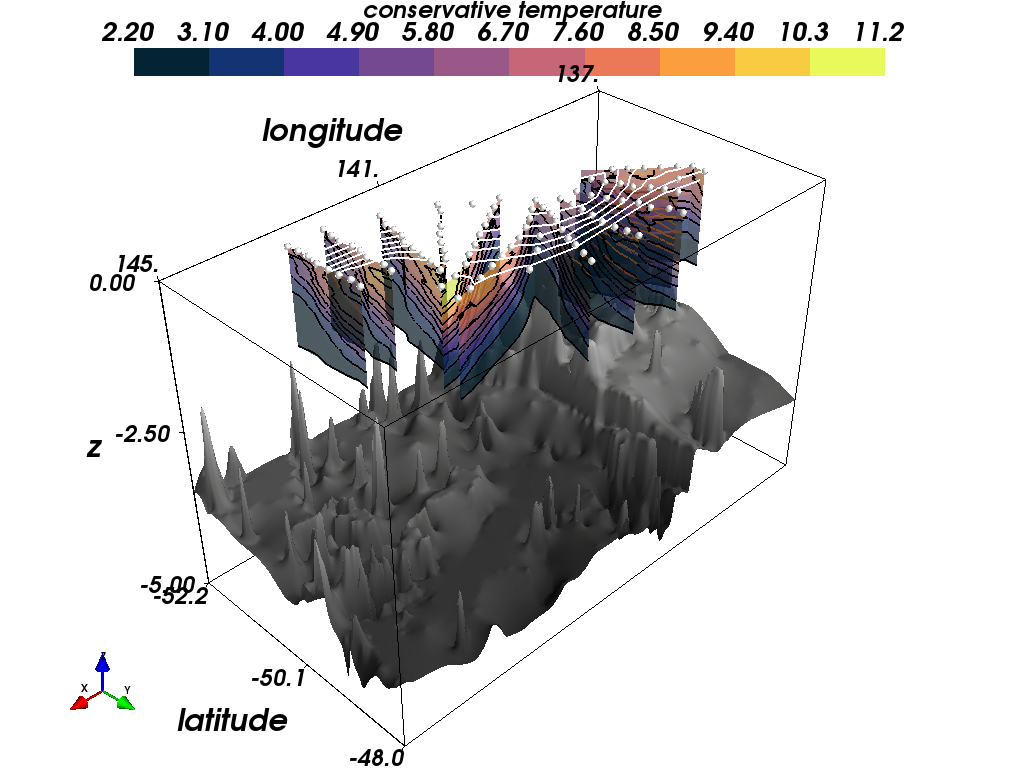

In [12]:
mintemp, maxtemp = 2.2, 11.2
bounds = list(np.linspace(2.2, 11.2, 10))
title = 'conservative temperature'

# plot
fig = mlab.figure(size=(1024,768), bgcolor=(1,1,1), fgcolor=(0,0,0))

# scale factor for z-axis
scalefac = 1e-3

ncolors = len(bounds)
# plot for each transect
for i in range(1,12):
    temp = CT[its(i)]
    temp[np.isnan(temp)] = 0

    sig0 = sigma0[its(i)]
    sig0[np.isnan(sig0)] = 0
    
    z = np.tile(-ctd['p'][:], (len(its(i)),1))
    x = np.meshgrid(ctd['p'], lon[its(i)])[1]
    y = np.meshgrid(ctd['p'], lat[its(i)])[1]
    
    # plot potential density fields
    msh = mlab.mesh(x, y, z, scalars=temp, opacity=0.7, vmin=mintemp, vmax=maxtemp)
    msh.actor.actor.scale = (1, 1, scalefac)
    change_cmap(msh, cmocean.cm.thermal, ncolors=ncolors)
    msh.module_manager.scalar_lut_manager.number_of_colors = ncolors

    # plot potential density contours
    mesh = mlab.pipeline.grid_source(x, y, z, scalars=temp)
    cs = mlab.pipeline.contour_surface(mesh, contours=bounds, color=(0, 0, 0))
    cs.actor.actor.scale = (1, 1, scalefac)
    cs.actor.mapper.scalar_visibility = False
colorbar = mlab.colorbar(msh, title=title, orientation='horizontal', nb_colors=ncolors, nb_labels=ncolors+1)
colorbar.scalar_bar_representation.position = [0.1, 0.9]
colorbar.scalar_bar_representation.position2 = [0.8, 0.1]

# plot dynamic height contours
iD = np.where(np.isfinite(D[2:]))[0]
ptsD = mlab.points3d(lon[iD], lat[iD], loc[iD], D[iD], color=(1, 1, 0.99), scale_mode='none', scale_factor=0.1)
mesh = mlab.pipeline.delaunay2d(ptsD)
cont = mlab.pipeline.contour_surface(mesh, contours=[0.72, 0.76, 0.8, 0.84, 0.88, 0.92], color=(1, 1, 1))
cont.actor.actor.scale = [1, 1, scalefac]
cont.actor.mapper.scalar_visibility = False

# plot bathymetry
dep = mlab.surf(loni, lati, elev, warp_scale=scalefac)
change_cmap(dep, cmocean.cm.gray)

mlab.outline(extent=[137, 145, -52.2, -48, -5000*scalefac, 0])
mlab.axes(xlabel='longitude', ylabel='latitude', zlabel='z', 
          extent=[137, 145, -52.2, -48, -5000*scalefac, 0], nb_labels=3)
mlab.orientation_axes()
mlab.show()

fig

In [13]:
animation = mpy.VideoClip(anim, duration=duration).resize(0.6)
animation.ipython_display(fps=fps, width=1024)

 99%|█████████▉| 90/91 [00:03<00:00, 27.20it/s]


In [14]:
# animation.write_videofile(os.path.join(outdir, 'ss9802', 'conservative_temperature.mp4'), fps=fps)


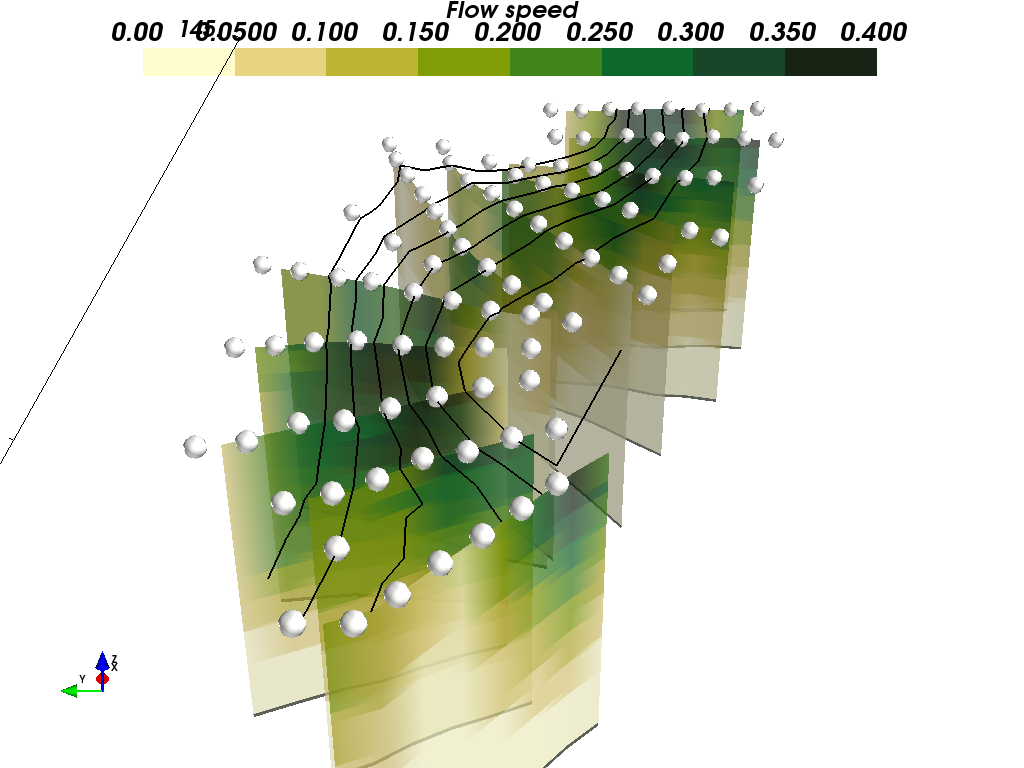

In [15]:
# plot
fig = mlab.figure(size=(1024,768), bgcolor=(1,1,1), fgcolor=(0,0,0))

ncolors = 8
# plot for each transect
idx = 0
for i in range(1,12):
    
    V = ctd['Vg'][idx: idx + len(its(i))-1]
    V[np.isnan(V)] = 0
    
    z = np.tile(-ctd['p'][:], (len(its(i))-1, 1))
    x = np.meshgrid(ctd['p'], ctd['lonv'][idx: idx + len(its(i))-1])[1]
    y = np.meshgrid(ctd['p'], ctd['latv'][idx: idx + len(its(i))-1])[1]
    
    idx += len(its(i))-1
    
    # plot potential density fields
    vmin, vmax = 0, 0.4
    msh = mlab.mesh(x, y, z, scalars=V, opacity=0.7, vmin=vmin, vmax=vmax)
    msh.actor.actor.scale = (1, 1, scalefac)
    change_cmap(msh, cmocean.cm.speed, ncolors=ncolors)
    msh.module_manager.scalar_lut_manager.number_of_colors = ncolors

colorbar = mlab.colorbar(msh, title='Flow speed', orientation='horizontal', nb_colors=ncolors, nb_labels=ncolors+1)
colorbar.scalar_bar_representation.position = [0.1, 0.9]
colorbar.scalar_bar_representation.position2 = [0.8, 0.1]

# plot dynamic height contours
iD = np.where(np.isfinite(D[2:]))[0]
ptsD = mlab.points3d(lon[iD], lat[iD], loc[iD], D[iD], color=(1, 1, 0.99), scale_mode='none', scale_factor=0.1)
mesh = mlab.pipeline.delaunay2d(ptsD)
cont = mlab.pipeline.contour_surface(mesh, contours=[0.72, 0.76, 0.8, 0.84, 0.88, 0.92], color=(0, 0, 0))
cont.actor.actor.scale = [1, 1, scalefac]
cont.actor.mapper.scalar_visibility = False

# mlab.outline(extent=[137, 145, -52.2, -48, -1600*scalefac, 0])
mlab.axes(xlabel='longitude', ylabel='latitude', zlabel='z', 
          extent=[137, 145, -52.2, -48, -1600*scalefac, 0], nb_labels=3)
mlab.orientation_axes()
mlab.view(azimuth=0, elevation=-60, distance=8)
mlab.show()

fig

In [16]:
import moviepy.editor as mpy
#mlab.view(azimuth=0, elevation=-60, distance=8)

fps = 3
frames = 18
duration = frames / fps
def anim(t):
    # rotate to top view of xy-plane
    if fps*t == 0:
        mlab.view(azimuth=0, elevation=0)
    # rotate around z-axis
    if 0 < fps*t < 10:
        mlab.view(azimuth=10 * fps * t, elevation=0)
    elif 10 <= fps*t < 13:
        mlab.view(azimuth=180, elevation=5 * fps * t)
    elif 13 <= fps*t < frames:
        mlab.move(forward=1.5)
        
    return mlab.screenshot()

animation = mpy.VideoClip(anim, duration=duration).resize(0.6)
animation.ipython_display(fps=fps, width=1024)

 95%|█████████▍| 18/19 [00:00<00:00, 31.70it/s]


In [17]:
# animation.write_videofile(os.path.join(outdir, 'ss9802', 'flow_speed.mp4'), fps=fps)

In [18]:
# Remove temporary files
cwd = os.getcwd()
[os.remove(os.path.join(cwd, f)) for f in os.listdir(cwd) if f.startswith('(null)') or f.startswith('__temp__')]


[None]